In [1]:
import numpy as np
import scipy.linalg as linalg
from JSAnimation import IPython_display
import matplotlib.pyplot as plt
from matplotlib import animation

from optic_flow import *

In [ ]:
def get_drifting_sinus(im_size,omega,theta,lambd):
    im_centre = (np.array(im_size[1:])/2).astype(int)
    x,t,y = np.meshgrid(np.arange(0,im_size[1]), np.arange(0,im_size[0]), np.arange(0,im_size[2]))
    k = 2*np.pi/lambd
    return  np.cos(k*(np.cos(theta)*(x-im_centre[0]) + np.sin(theta)*(y-im_centre[1])-omega*t))  

def get_drifting_sinusoids(im_size,omega,theta,lambd):
    x,t,y = np.meshgrid(np.arange(0,im_size[1]), np.arange(0,im_size[0]), np.arange(0,im_size[2]))
    response = np.zeros(im_size)
    
    for om, thet, lambd_ in zip(omega, theta, lambd):
        
        response += get_drifting_sinus(im_size, om, thet, lambd_)
    response /= len(omega)
    return response

In [ ]:
%matplotlib inline

im_shape = (51,71,61)

stimulus = get_drifting_sinusoids(im_shape, [1/np.sqrt(2),1/np.sqrt(2)], [np.pi/4,-np.pi/4], [10,10])

def animate(i):
    im.set_array(stimulus[i,:,:].T)
    return im

vmin1 = stimulus.min(); vmax1 = stimulus.max()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
im = ax.imshow(stimulus[0,:,:].T, cmap="jet")
fig.colorbar(im)
animation.FuncAnimation(fig, animate, frames=stimulus.shape[0], interval=50)

In [ ]:
# import matlab.engine
# eng = matlab.engine.start_matlab()
# stimulus2 = eng.optic_flow(200, 0.,  0., .5, 1);
# stimulus2 = np.array(stimulus2)

In [ ]:
# vmin2 = stimulus2.min(); vmax2 = stimulus2.max()

# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# im = axes[0].imshow(stimulus2[0,:,:].T, cmap="jet", vmin = vmin2, vmax = vmax2)
# im_show.append(im)
# animation.FuncAnimation(fig, animate, frames=stimulus2.shape[0], interval=50)

In [64]:
%%time
# v_x, v_y = optic_flow(stimulus)

T = np.array([[1],[1],[1]])
Omega = np.array([[0],[0],[0]])
f = 30
time = 51
x_shape = 71
y_shape = 61
v_x, v_y = get_artificial_optic_flow(f,time,x_shape,y_shape,T,Omega)

/home/sharbat/UPMC/piof/optic_flow.py:84: RuntimeWarning: invalid value encountered in true_divide
  v_xy = v_xy/linalg.norm(v_xy)


CPU times: user 11.5 s, sys: 44 ms, total: 11.5 s
Wall time: 11.4 s


<IPython.core.display.Javascript object>


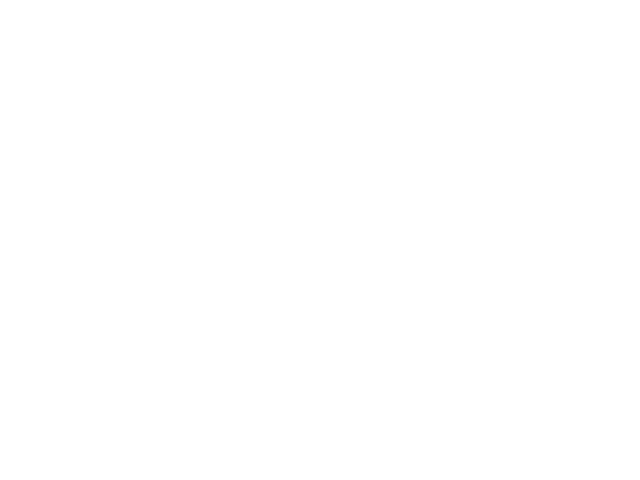


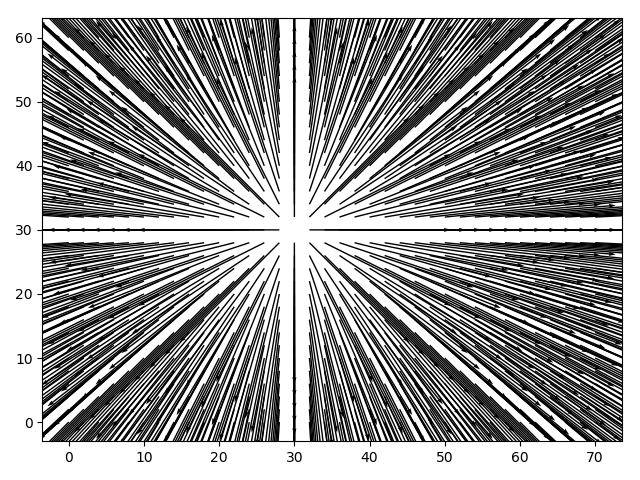
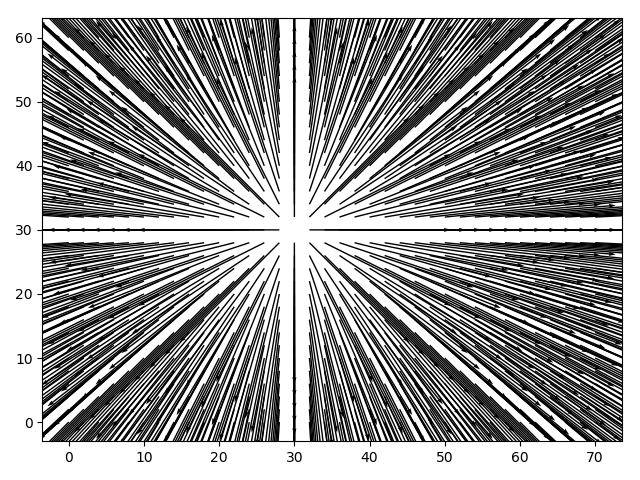
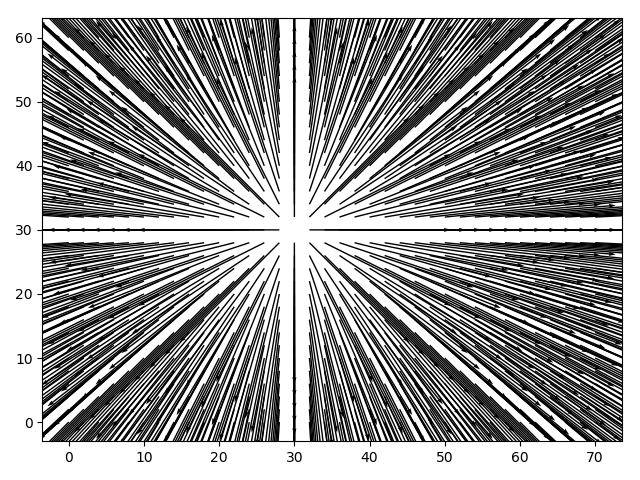
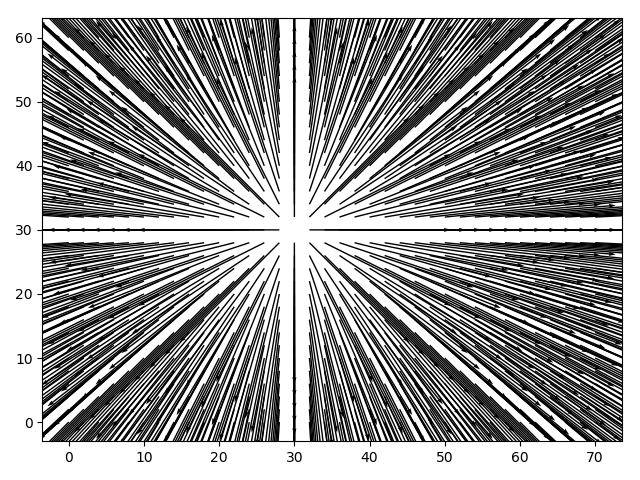
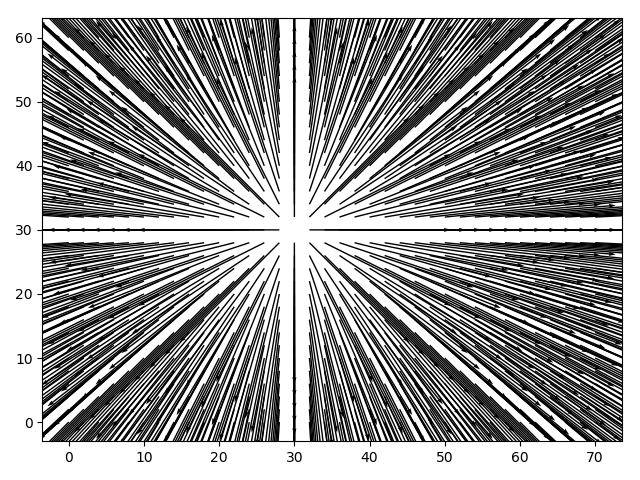
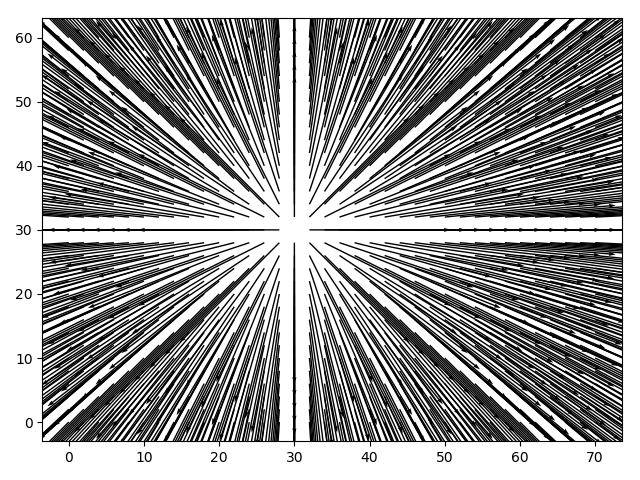
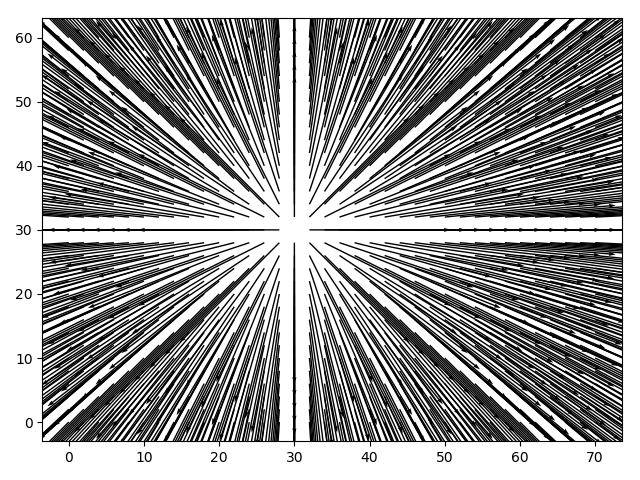
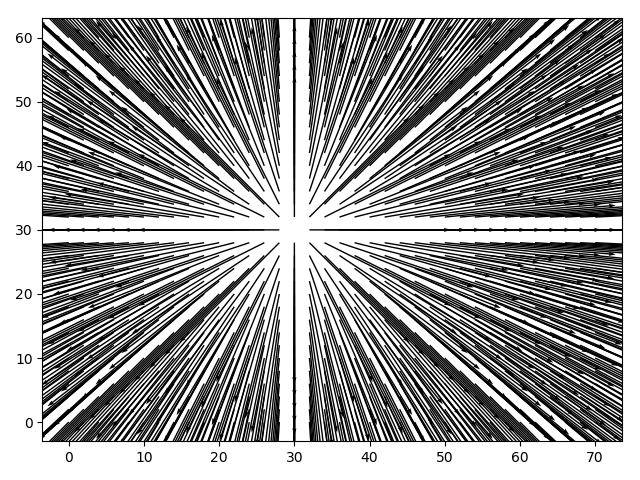
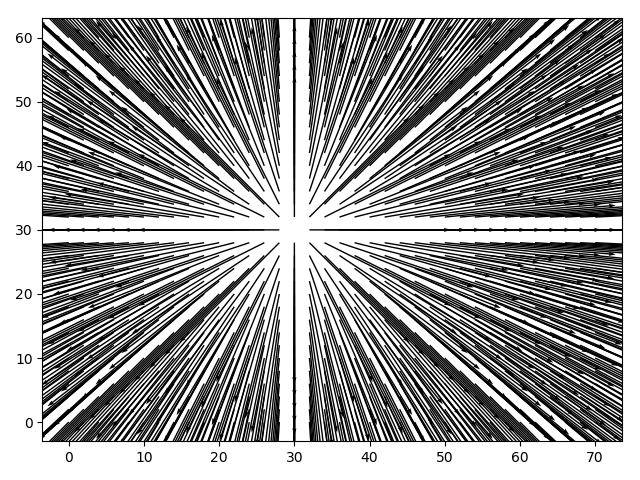
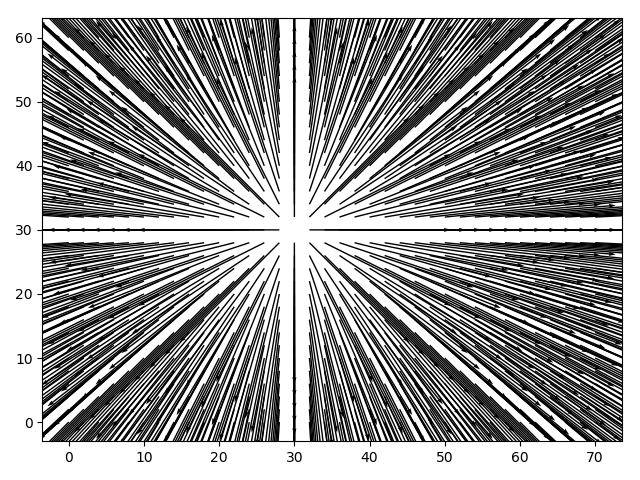
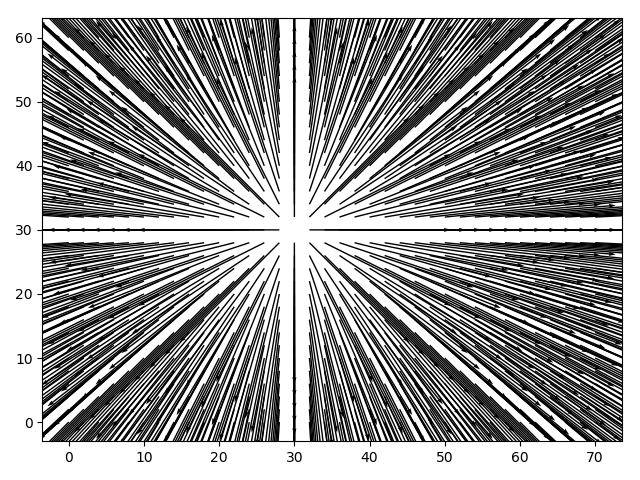
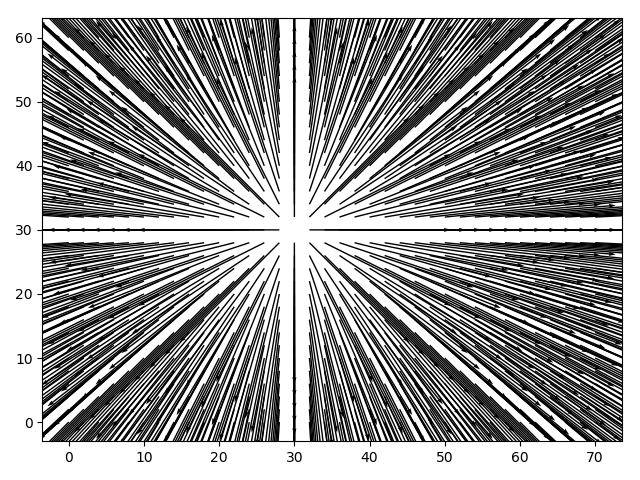
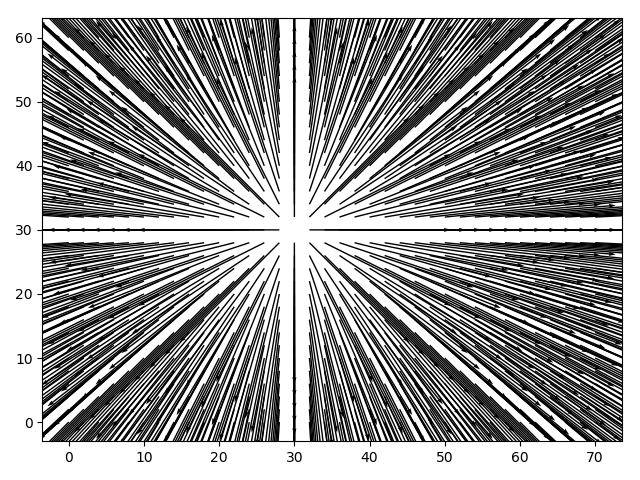
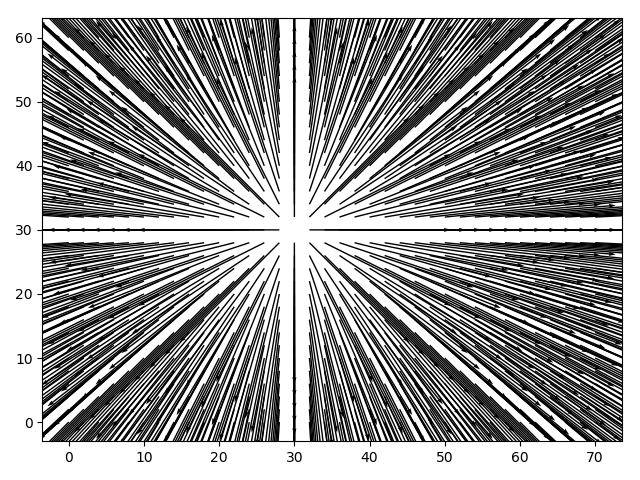
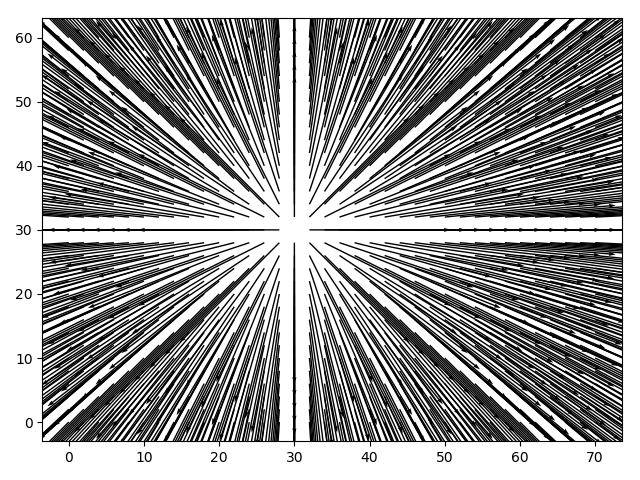
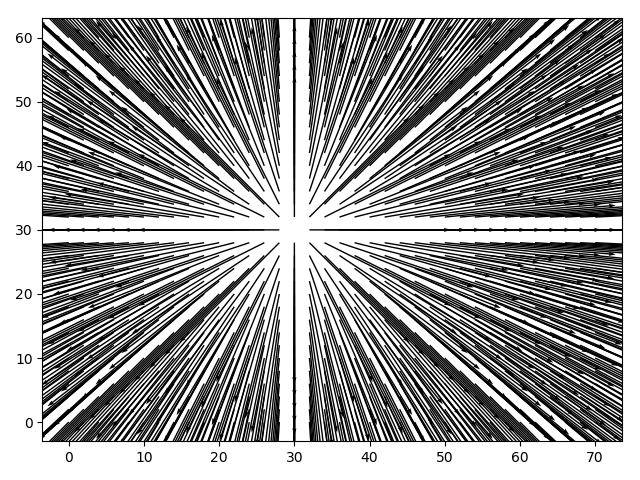
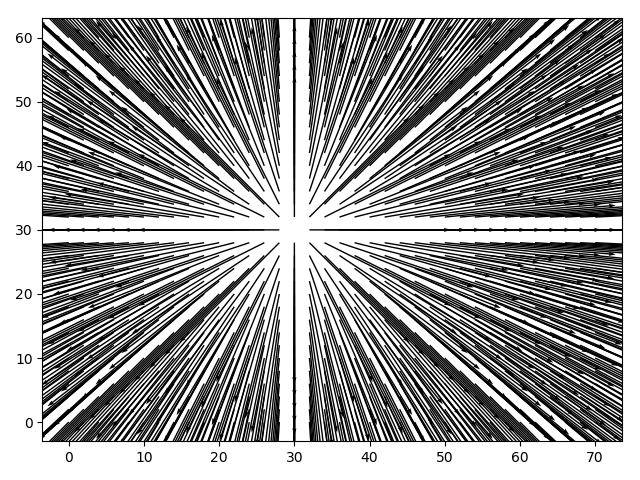
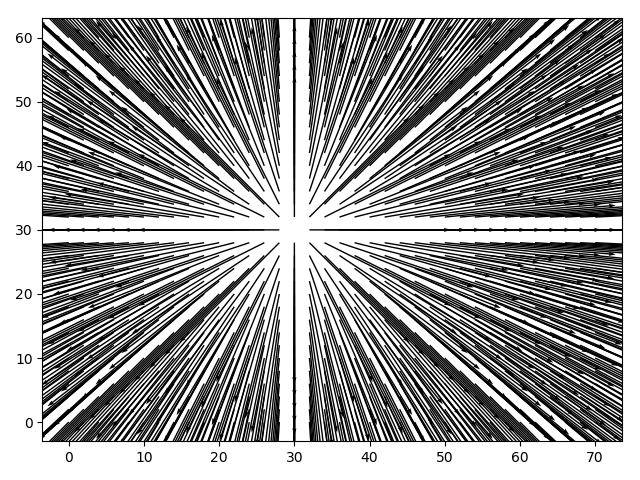
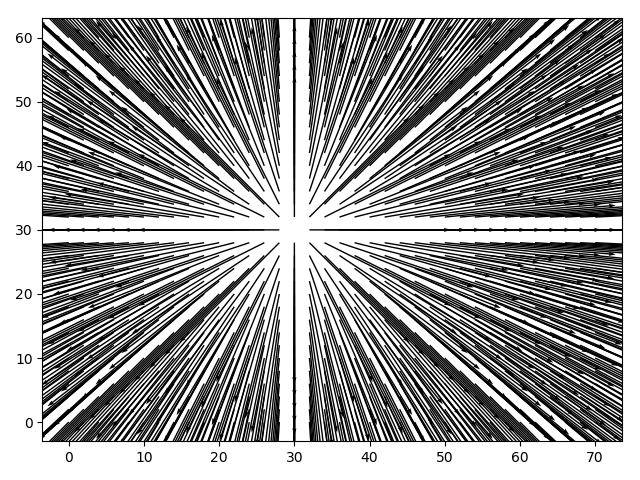
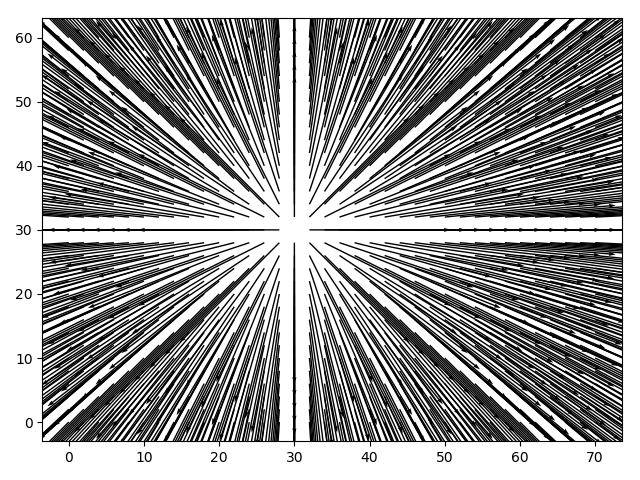

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111)
spacing = 2
im_show = []
(X, T, Y) = np.meshgrid(np.arange(0, x_shape), np.arange(0, time), np.arange(0, y_shape))
Q = ax.quiver(X[0,::spacing,::spacing], Y[0,::spacing,::spacing], 
                   v_x[0,::spacing,::spacing], v_y[0,::spacing,::spacing], 
                    pivot='tail', color='k', units='xy', scale = .05)
im_show.append(Q)
def animate(i):  
    """
        Dynamically setting what is displayed on the different plots.
    """
    im_show[0].set_UVC(v_x[i,::spacing,::spacing],v_y[i,::spacing,::spacing])
    return im_show
plt.tight_layout()

animation.FuncAnimation(fig, animate, frames=T.shape[0], interval=50)

<IPython.core.display.Javascript object>


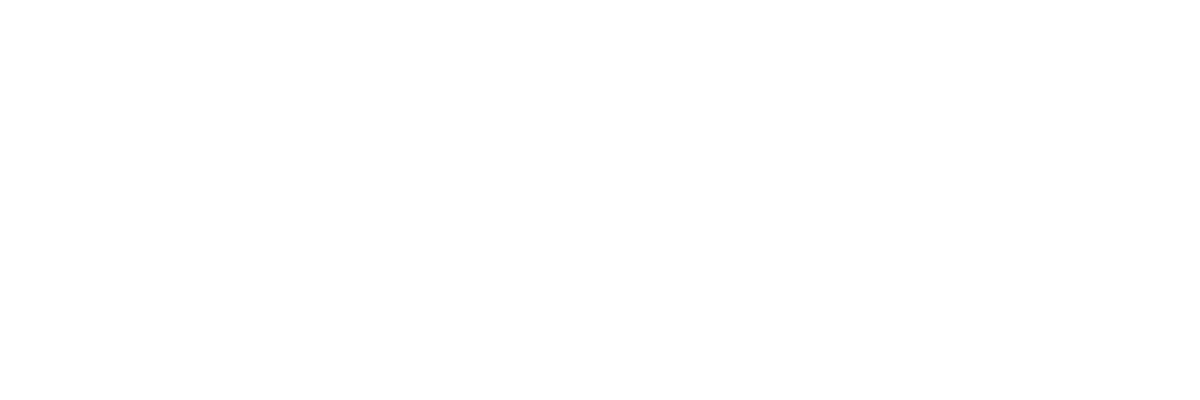

NameError: name 'stimulus' is not defined

In [66]:
fig = plt.figure(figsize=(12,4))

axes = []
im_show = []

(X, T, Y) = np.meshgrid(np.arange(0, stimulus.shape[1]), np.arange(0,  stimulus.shape[0]), np.arange(0, stimulus.shape[2]))

axes.append(fig.add_subplot(1,2,1))

vmin1 = stimulus.min(); vmax1 = stimulus.max()

im = axes[0].imshow(stimulus[0,:,:].T, cmap="jet", vmin = vmin1, vmax = vmax1)
im_show.append(im)

axes.append(fig.add_subplot(1,2,2))

spacing = 2

Q = axes[1].quiver(X[0,::spacing,::spacing], Y[0,::spacing,::spacing], 
                   v_x[0,::spacing,::spacing], v_y[0,::spacing,::spacing], 
                    pivot='tail', color='k', units='xy', scale = .05)#.0002)
im_show.append(Q)

plt.axis('equal')
for j, ax in enumerate(axes):
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    if j == 1:
        ax.set_xlim([0, stimulus.shape[1]])
        ax.set_ylim([stimulus.shape[2],0])

def animate(i):  
    """
        Dynamically setting what is displayed on the different plots.
    """
    im_show[0].set_array(stimulus[i,:,:].T)
    im_show[1].set_UVC(v_x[i,::spacing,::spacing],v_y[i,::spacing,::spacing])
    return im_show

plt.tight_layout()

animation.FuncAnimation(fig, animate, frames=T.shape[0], interval=50)

## Estimating the velocity (translation and rotation) and depth of the stimulus 

Just from the optic flow information, the translation (only the direction, because the absolute translation and the depth are multiplied in equations for their estimation), the rotation and the depth (with some amount of error) can be obtained, using a linear subspace method as outlined by Heeger and Jepson (1992), and reviewed in Raudies and Neumann (2012).

### Estimating the direction of translation
The translation vector (henceforth a unit vector, $T$) can be recovered by calculating the estimated minimum of the residual function $E(T)$ calculated as follows. $v(x,y)$ represents the velocity (optic flow) at the point $(x,y)$ in the 2D optic plane, and $C(T)$ is a calculated matrix which does not need the optic flow information and hence can be precomputed in a parallel way beforehand from the image characteristics ( ( $\textbf{TO BE DONE!!}$ ) ):

$$
\begin{equation}
v(x,y) = p(x,y)A(x,y)T + B(x,y)\Omega
\end{equation}\\
p(x,y) = \frac{1}{Z} \\
A(x,y) =
\begin{bmatrix}
-f & 0 & x \\
0 & -f & y \\
\end{bmatrix}\\
B(x,y) =
\begin{bmatrix}
(xy)/f & -(f + x^{2}/f) & y\\
f + y^{2}/f & -(xy)/f & -x\\
\end{bmatrix}\\
A(T) = 
\begin{bmatrix}
A(x_{1},y_{1})T & \cdots & 0 \\
\vdots & \ddots & \vdots \\
0 & \cdots & A(x_{N},y_{N})T\\
\end{bmatrix}\\
B = 
\begin{bmatrix}
B(x_{1},y_{1}) \\
\vdots \\
B(x_{N},y_{N})\\
\end{bmatrix}\\
C(T) = 
\begin{bmatrix}
\vdots & \vdots\\
A(T) & B\\
\vdots & \vdots\\
\end{bmatrix}\\
$$

Once we calculate $C(T)$, we calculate the residual function $E(T)$ as follows :

$$
E(T) = ||v^{t}C^{\bot}(T)||^{2}
$$
where $C^{\bot}(T)$ is an orthogonal complement to $C(T)$. The minimum argument of $T$ which achieves this is taken to be the candidate translation direction. 


In [67]:
def sample_T(): #to get a systematic number of T's (use for ||n later)
    for theta in np.arange(0,np.pi,0.01):
        for phi in np.arange(0,np.pi,0.01):
            x = np.cos(theta)*np.sin(phi)
            y = np.sin(theta)*np.sin(phi)
            z = np.cos(phi)
    return np.array([[x],[y],[z]])

def calculate_perp_CT(sample_points, T): #input the presampled sample points - can be precalculated
    N = np.shape(sample_points)[0]; #justincase
    A_T = np.zeros([2*N,N]) #preallocate ndarrays for storing the matrices
    B = np.zeros([2*N,3])
    
    for i in np.arange(0,N,1):
        x,y = sample_points[i,0],sample_points[i,1]
        
        #calculating A_T
        A = np.array([[-f,0,x],[0,-f,y]])
        AtimesT = np.dot(A,T)
        A_T[2*i,i], A_T[2*i+1,i] = AtimesT[0], AtimesT[1]
        
        #calculating B
        B[2*i] = np.array([(x*y)/f, -(f + (x*x)/f), y])
        B[2*i+1] = np.array([f + (y*y)/f, -(x*y)/f, -x])
    return linalg.orth(np.concatenate((A_T,B),axis=1)) 

## Add the saved and parallelised version of the C(T) calculations here and put an estimate of the time and memory needed for the same (TO BE DONE!!)

In [68]:
%%time
stim_time = time
x_lim = x_shape
y_lim = y_shape
N = 10 #number of random points
f = 30 #focal length
search_range = np.arange(0,np.pi,0.01)
E = np.zeros((np.size(search_range),np.size(search_range)))

for time in np.arange(20,21,1): #change to allow for time streaming
    ## gather some sample points
    sample_points = np.transpose([np.random.randint(x_lim/2-20,x_lim/2,size=N),np.random.randint(y_lim/2-20,y_lim/2,size=N)])
    sample_v_x, sample_v_y = v_x[time,sample_points[:,0],sample_points[:,1]], v_y[time,sample_points[:,0],sample_points[:,1]]

    ## run through all candidate translation directions
    for idtheta,theta in enumerate(list(search_range)):
        for idphi,phi in enumerate(list(search_range)):
            x = np.cos(theta)*np.sin(phi)
            y = np.sin(theta)*np.sin(phi)
            z = np.cos(phi)
            T = np.array([[x],[y],[z]])
            
            perp_CT = calculate_perp_CT(sample_points, T)
            v_t = np.vstack((sample_v_x,sample_v_y)).reshape((-1),order='F').reshape(1,2*N) #v is concat of all sample point vels 
            E_T = (np.linalg.norm(np.dot(v_t,perp_CT)))**2
            E[idtheta,idphi] = E_T        

CPU times: user 2min 23s, sys: 860 ms, total: 2min 23s
Wall time: 36 s


<IPython.core.display.Javascript object>


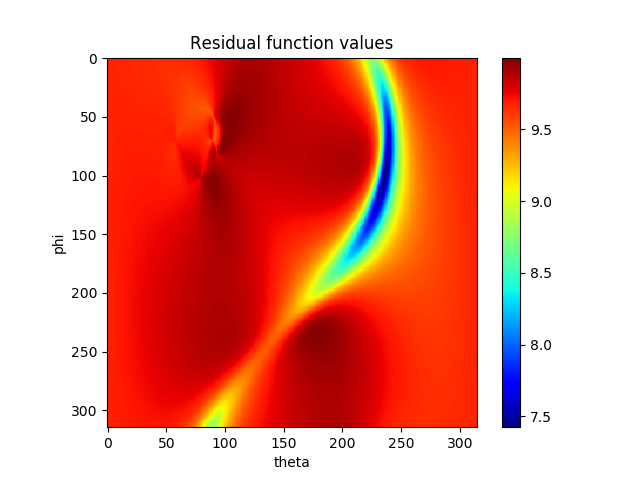

[[ 0.1771751 ]
 [-0.96584173]
 [-0.18909982]]


In [73]:
#plotting residual surfaces
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('theta')
ax.set_ylabel('phi')
im = ax.imshow(E, cmap="jet")
fig.colorbar(im)
ax.set_title('Residual function values')
theta, phi = np.unravel_index(E.argmin(), E.shape)
x = np.cos(theta)*np.sin(phi)
y = np.sin(theta)*np.sin(phi)
z = np.cos(phi)
T = np.array([[x],[y],[z]])
print(T)

### Estimating the value of rotation, given the direction of translation

The estimate of $\Omega$ is given by the following : 
$$
\hat{\Omega} = \Bigg[ \sum_{i}B^{t}_{i}d_{i}d^{t}_{i}B_{i} \Bigg]^{-1} \Bigg[ \sum_{i}B^{t}_{i}d_{i}d^{t}_{i}v_{i} \Bigg]
$$

In [70]:
#estimating rotation given the translation

N = np.shape(sample_points)[0]; #justincase
f = 30
sum_left = np.zeros([3,3])
sum_right = np.zeros([3,1])

for time in np.arange(20,21,1):
    for i in np.arange(0,N,1):
        x,y = sample_points[i,0],sample_points[i,1]

        #calculating d
        A = np.array([[-f,0,x],[0,-f,y]])
        AtimesT = np.dot(A,T)
        d = np.array([[AtimesT[1,0]],[-AtimesT[0,0]]])
        di = d/linalg.norm(d)

        #calculating left term in omega estimate
        Bi = np.array([[(x*y)/f, -(f + (x*x)/f), y],[f + (y*y)/f, -(x*y)/f, -x]])
        sum_left += np.dot(np.transpose(Bi),np.dot(di,np.dot(np.transpose(di),Bi)))
        
        #calculating right term in omega estimate
        sample_v_x,sample_v_y = v_x[time,x,y],v_y[time,x,y]
        vi = np.array([[sample_v_x],[sample_v_y]])
        sum_right += np.dot(np.transpose(Bi),np.dot(di,np.dot(np.transpose(di),vi)))

omega = np.dot(linalg.inv(sum_left),sum_right)
print(omega)

[[ 0.02515726]
 [ 0.01540706]
 [-0.07050327]]


### Estimating the value of the depth given the direction of translation and the rotation
From the equation $v(x,y) = p(x,y)A(x,y)T + B(x,y)\Omega$, we can substitute the values of $T$ and $\Omega$ to get the estimated depth at every point of the image

In [71]:
#calculating depth
depth_mat = np.zeros([np.size( np.arange(0,x_lim,1)),np.size( np.arange(0,y_lim,1))])
for x in np.arange(0,x_lim,1):
    for y in np.arange(0,y_lim,1):
        A = np.array([[-f,0,x],[0,-f,y]])
        B = np.array([[(x*y)/f, -(f + (x*x)/f), y],[f + (y*y)/f, -(x*y)/f, -x]])
        v = np.array([[v_x[10,x,y]],[v_y[10,x,y]]])
        scaled_AT = v - np.dot(B,omega)
        depth_mat[x,y] = np.mean(np.dot(A,T)/scaled_AT)

depth_mat = np.clip(depth_mat,0,np.mean(depth_mat)+np.std(depth_mat))


<IPython.core.display.Javascript object>


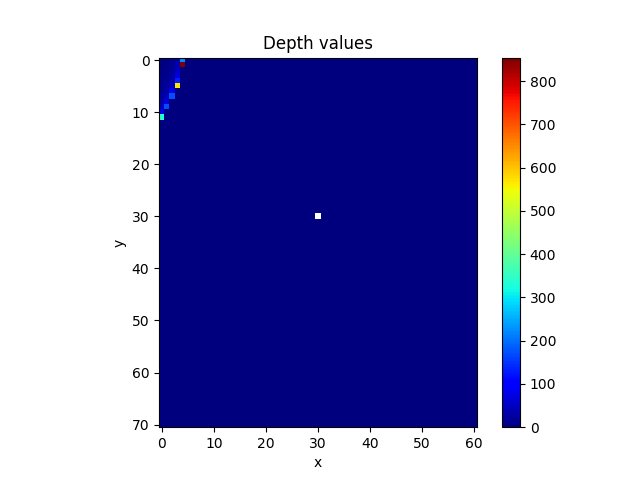

In [72]:
#plotting depth
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('x')
ax.set_ylabel('y')
im = ax.imshow(depth_mat, cmap="jet")
fig.colorbar(im)
ax.set_title('Depth values')

If it is true that the edge effects are causing this, then why for the love of Paris is this not symmetric?

In [ ]:
#testing whether things make sense
